# Segmentation Training

## Import Packages

In [1]:
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import matplotlib
import random
import torch

## Data Preparation

In [2]:
from data.dataset import SegmentationDataset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

1. Define data transforms

In [3]:
data_transforms = transforms.Compose([
    transforms.ToTensor()
])

2. Load the dataset and create the dataloader

In [4]:
data_dir = "path_to_slide_folder"
annotation_dir = "/Volumes/SLIDES/Slides/SegmentationMultiScanner/scc-full-res.json"
dataset = SegmentationDataset(image_path=data_dir, anno_file_path= annotation_dir, num_per_slide = 10, patch_size = 512, ds_level = 2, transforms=data_transforms)
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [0.8, 0.2])
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=False, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=0, pin_memory=True)
classes = {'-1':'non-annotated', '0': 'background', '1': 'non-tumor', '2': 'tumor'}
norm = matplotlib.colors.Normalize(vmin=-1, vmax=2)

3. Show slide annotations

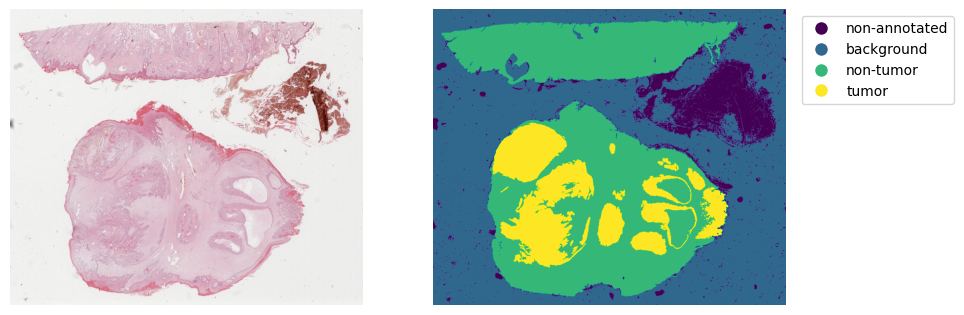

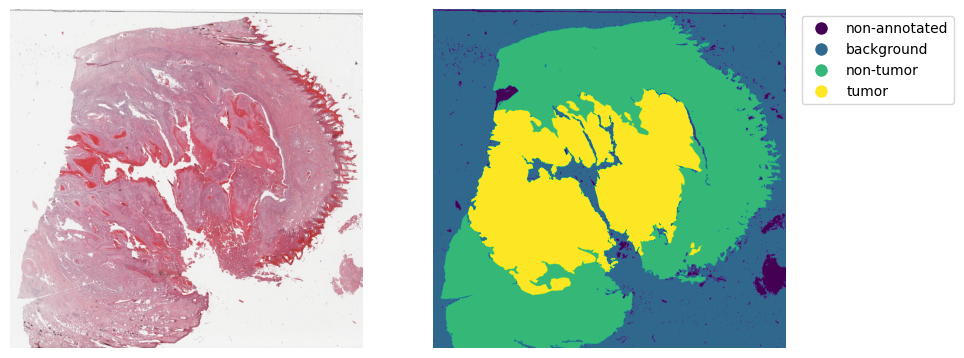

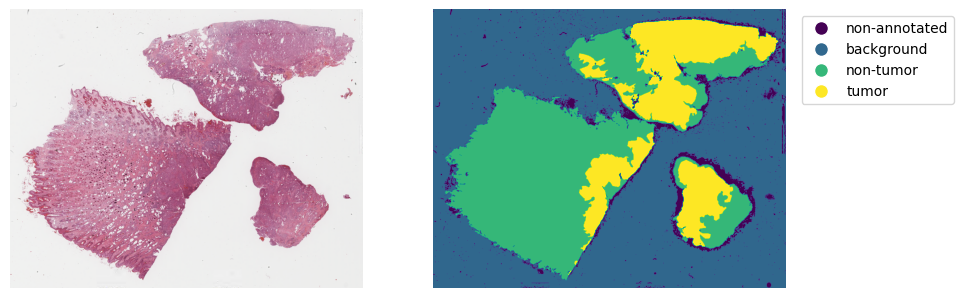

In [5]:
random_indices = random.sample(range(len(train_dataset)), 3)
for idx in random_indices:
    map, thumb = dataset.__getoverview__(idx)
    unique_classes = sorted(list(set(map.flatten())))
    # Create a custom legend based on class labels
    legend_labels = [f'{classes[str(label)]}' for label in unique_classes]
    legend_colors = matplotlib.colormaps['viridis']
    fig, axes = plt.subplots(1, 2, figsize=(10,15))
    axes[0].imshow(thumb)
    axes[0].axis("off")
    cax = axes[1].imshow(map, vmin=-1, vmax=2, cmap='viridis')
    axes[1].axis("off")
    # Add legend
    legend = axes[1].legend(handles=[plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=legend_colors(norm(i)), markersize=10) for i in unique_classes],
                            labels=legend_labels, loc='upper right', bbox_to_anchor=(1.5, 1.0))

4. Show some example patches

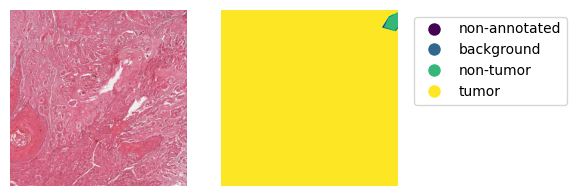

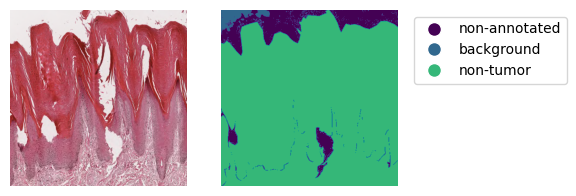

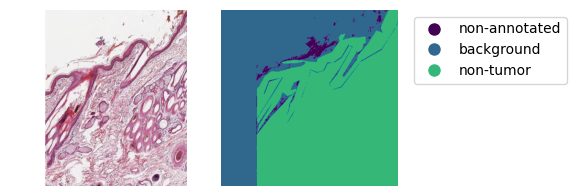

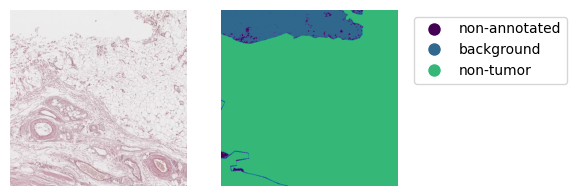

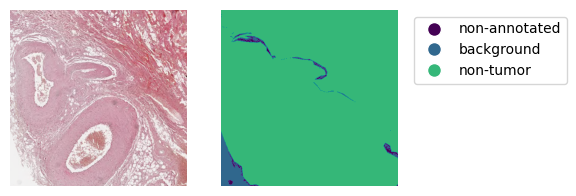

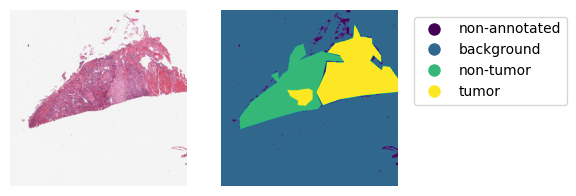

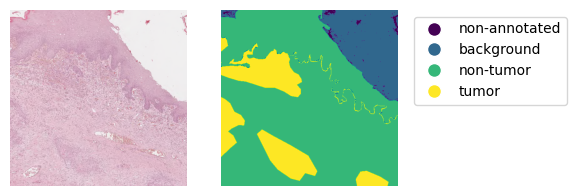

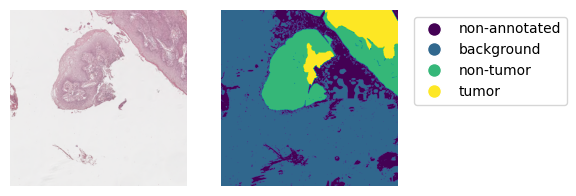

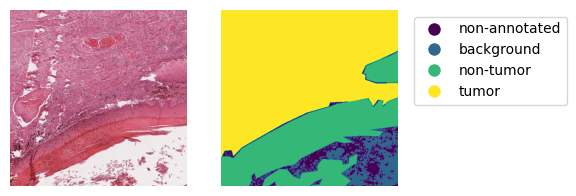

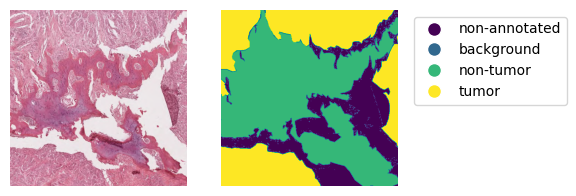

In [6]:
random_indices = random.sample(range(len(train_dataset)), 10)
samples= [train_dataset[i] for i in random_indices]

for i in range(len(samples)):
    fig, axes = plt.subplots(1, 2, figsize=(5,10))
    sample = samples[i]
    img = sample[0].cpu().numpy().transpose(1, 2, 0)
    img = 255*img
    label = sample[1].squeeze().cpu().numpy()
    unique_classes = sorted(list(set(label.flatten())))
    # Create a custom legend based on class labels
    legend_labels = [f'{classes[str(label)]}' for label in unique_classes]
    legend_colors = matplotlib.colormaps['viridis']
    axes[0].imshow(img)
    axes[0].axis("off")
    cax = axes[1].imshow(label, vmin=-1, vmax=2, cmap='viridis')
    axes[1].axis("off")
    # Add legend
    legend = axes[1].legend(handles=[plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=legend_colors(norm(i)), markersize=10) for i in unique_classes],
                            labels=legend_labels, loc='upper right', bbox_to_anchor=(2, 1.0))

plt.show()

## Model Preparation

In [7]:
from segmentation_models_pytorch import Unet
import torch.optim as optim
import torch.nn as nn

1. Configure model, optimizer, scheduler, and loss criterion

In [8]:
model = Unet(encoder_name='resnet34', classes=3)
device = torch.device('mps')

2. Train the model

In [10]:
model.train()
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
criterion = nn.CrossEntropyLoss(ignore_index=-1)

num_epochs = 5
itr = 1

for epoch in range(num_epochs):
    
    for inputs, targets in train_loader:
        outputs = model(inputs.to(device))
        loss_value = criterion(outputs, targets.squeeze(1).long().to(device))

        optimizer.zero_grad()
        loss_value.backward()
        optimizer.step()

        print(f"Iteration #{itr} loss: {loss_value}")
        itr += 1
    
    # update the learning rate
    if lr_scheduler is not None:
        lr_scheduler.step()

Iteration #1 loss: 1.3072013854980469
Iteration #2 loss: 1.2903512716293335
Iteration #3 loss: 1.1451777219772339
Iteration #4 loss: 1.0603936910629272
Iteration #5 loss: 1.2028508186340332
Iteration #6 loss: 1.0270678997039795
Iteration #7 loss: 1.0510262250900269
Iteration #8 loss: 1.210736870765686
Iteration #9 loss: 0.9170129895210266
Iteration #10 loss: 1.0534671545028687
Iteration #11 loss: 0.9672820568084717
Iteration #12 loss: 0.8756023645401001
Iteration #13 loss: 0.914712131023407
Iteration #14 loss: 0.9538666009902954
Iteration #15 loss: 0.866277813911438
Iteration #16 loss: 0.8774982690811157
Iteration #17 loss: 0.7799052000045776
Iteration #18 loss: 0.88810133934021
Iteration #19 loss: 0.8481334447860718
Iteration #20 loss: 0.8326296806335449
Iteration #21 loss: 0.8698630332946777
Iteration #22 loss: 0.7156381011009216
Iteration #23 loss: 0.7694924473762512
Iteration #24 loss: 0.7961956858634949
Iteration #25 loss: 0.8019053339958191
Iteration #26 loss: 0.6754904389381409


3. Visualize Predictions

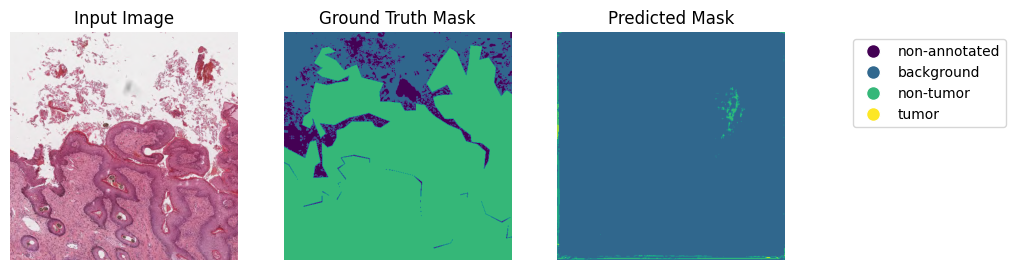

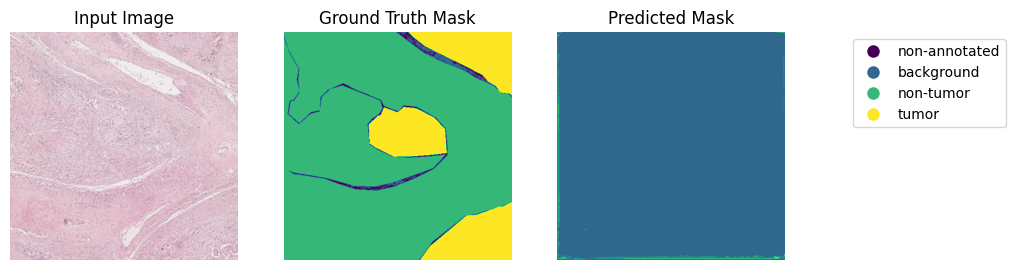

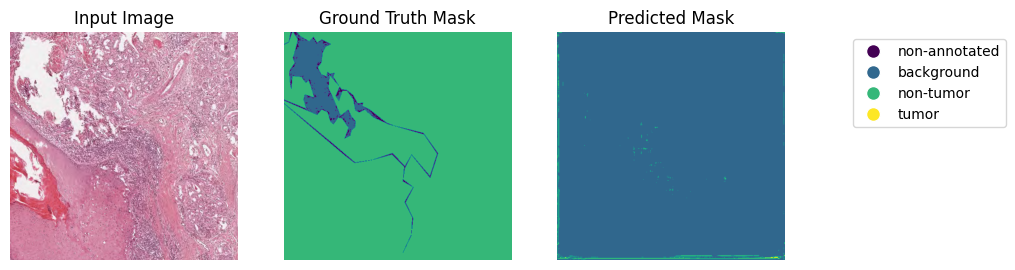

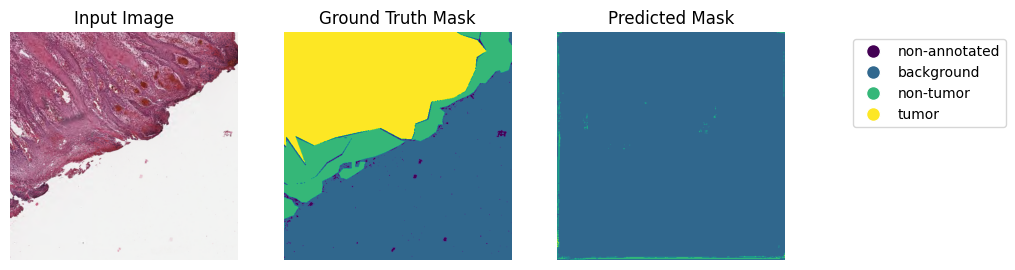

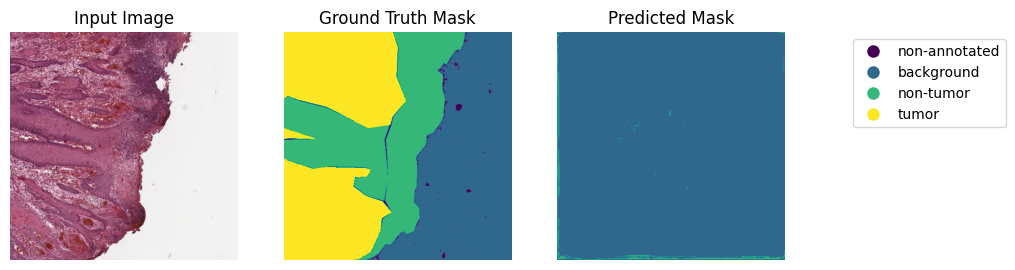

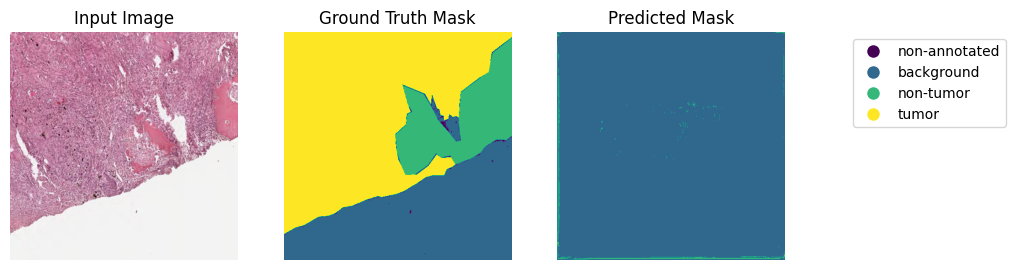

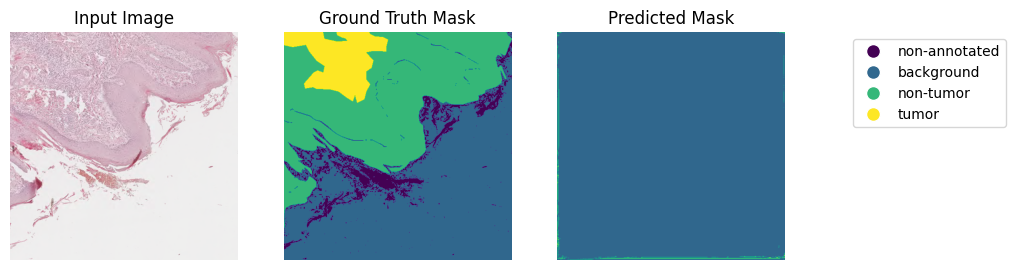

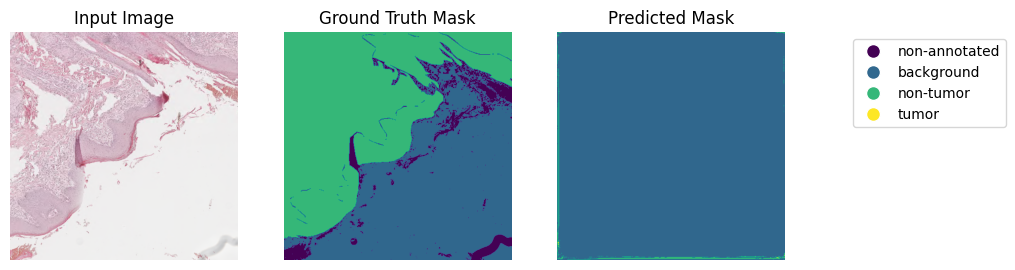

In [11]:
model.eval()
model.to(device)
images, targets = next(iter(val_loader))
images, targets = images.to(device), targets.to(device)

with torch.no_grad():
    outputs = model(images)

    pred_masks = torch.argmax(outputs, dim=1).cpu().numpy()

    for i in range(images.shape[0]):
        plt.figure(figsize=(10, 5))

        # Display the input image
        plt.subplot(1, 3, 1)
        img = transforms.ToPILImage()(255*images[i].cpu())
        plt.imshow(img)
        plt.axis('off')
        plt.title('Input Image')

        # Display the ground truth mask
        plt.subplot(1, 3, 2)
        ground_truth = targets[i].squeeze().cpu().numpy()
        plt.imshow(ground_truth, vmin=-1, vmax=2)
        plt.axis('off')
        plt.title('Ground Truth Mask')

        # Display the predicted mask
        plt.subplot(1, 3, 3)
        plt.imshow(pred_masks[i], vmin=-1, vmax=2)
        plt.axis('off')
        plt.title('Predicted Mask')

        unique_classes = sorted(list(set(ground_truth.flatten()) | set(pred_masks[i].flatten())))
        # Create a custom legend based on class labels
        legend_labels = [f'{classes[str(label)]}' for label in unique_classes]
        legend_colors = matplotlib.colormaps['viridis']

        # Add legend
        legend = plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=legend_colors(norm(i)), markersize=10) for i in unique_classes],
                            labels=legend_labels, loc='upper right', bbox_to_anchor=(2, 1.0))

        plt.show()